# Importing Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

# Reading and Merging Data

In [5]:
import zipfile

extract_dir = "./LUFlow"

if not os.path.exists("./LUFlow"):

    zip_file_path = "./LUFlow.zip"

    # Open the zip file and extract all the files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print("Files extracted successfully.")
else:
    print('Already extracted')

Already extracted


In [6]:
df_list = []
i = 0

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        # checks if 'file' does not exist in the directory
        # checks if 'csv' is in the file name
        # checks if a particular string is in the file name
        # insert in the list only a subset of the existing files
        if not os.path.isfile(file) and 'csv' in file and '2021.01' in file and i < 6:
            df_list.append(pd.read_csv(os.path.join(root, file)))
            i+=1

perc = 0.8

files_perc = int(len(df_list) * perc)
print(f'Num files: {files_perc}')

df = pd.concat(df_list[:files_perc])
df_test = pd.concat(df_list[files_perc:])

df = pd.concat(df_list, ignore_index=True)
len(df.columns)

Num files: 4


16

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348790 entries, 0 to 2348789
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      float64
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(6), int64(9), object(1)
memory usage: 286.7+ MB


# Exploratory Data Analysis

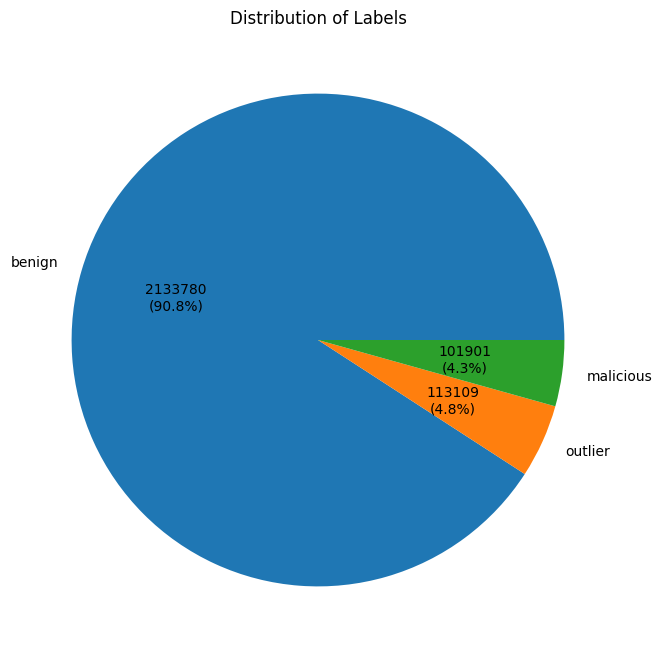

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

# Data Preprocessing

In [9]:
outliers = df['label'] == 'outlier'
df = df[~outliers]

df = df.reset_index(drop=True)

In [10]:
outliers = df_test['label'] == 'outlier'
df_test = df_test[~outliers]

df_test = df_test.reset_index(drop=True)

In [11]:
columns_to_drop = ['avg_ipt', 'dest_ip', 'dest_port', 'entropy', 'src_ip', 'src_port', 'time_end', 'total_entropy', 'duration']

# Drop specified columns
df = df.drop(columns=columns_to_drop)

df_test = df_test.drop(columns=columns_to_drop)

In [12]:
df.dropna(axis=1, inplace = True)
df_test.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()

print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the label column
df['label'] = label_encoder.fit_transform(df['label'])
df_test['label'] = label_encoder.fit_transform(df_test['label'])

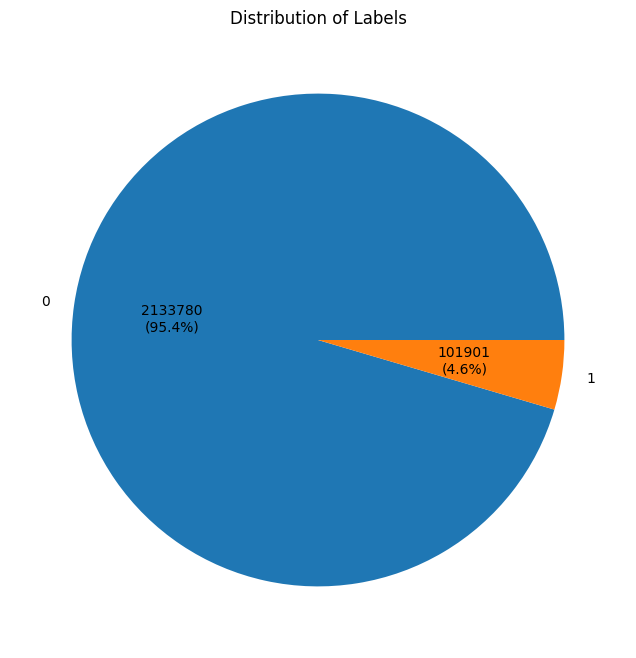

In [14]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))
# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [15]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

## Construction of Interval Information Granules

### Selecting index using time windows

In [16]:
time_slices = [16, 128, 256, 1024, 2048, 3016]

matching_indices_slices = {}

for ts in time_slices:
  # maximum time limit of the granule
  limit = df.iloc[0]['time_start'] + ts
  # number of groups for time_slice
  num_group = 0
  matching_indices_slices[ts] = {num_group:[0]}

  for i, row in df.iterrows():
      # if the value of time_start is greater than limit then limit is updated and
      # it is initilized a new group
      # otherwise the index of the row is added to matching_indeces_slices
      if row['time_start'] >= limit:
        limit = row['time_start'] + ts
        num_group += 1

        matching_indices_slices[ts][num_group] = [i]
      else:
        # print(ts, num_gran, i)
        if i != 0:
          matching_indices_slices[ts][num_group].append(i)


### Drop Label column

In [17]:
# Separate features (X) and target variable (y)
X_train = df.drop('label', axis=1)
y_train = df['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [18]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
0,969,10051,7,7,6,1609467672690358
1,967,23531,10,7,6,1609467672689065
2,754,32742,32,20,6,1609467672683006
3,588,13833,57,34,6,1609467682094405
4,0,224,7,0,17,1609467685597113
...,...,...,...,...,...,...
2235676,325,17926,6,3,6,1609977543854007
2235677,1063,54305,15,8,6,1609977523845996
2235678,232,54428,11,7,6,1609977543851036
2235679,663,8563,4,4,6,1609977555862131


In [19]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
2235676    0
2235677    0
2235678    0
2235679    0
2235680    0
Name: label, Length: 2235681, dtype: int64

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import math

### Creating interval information granules

with justifiable granularity principle


implementing both 'a' and 'b' to define the frames to include in the granule

In [21]:
X_train_granule = {}
y_train_granule = {}

experimental_data = {}

alpha = 2.0
l = 100

for time_slice in tqdm(time_slices):
  X_train_granule[time_slice] = {}
  y_train_granule[time_slice] = {}

  experimental_data[time_slice] = {}

  for group in matching_indices_slices[time_slice]:

    V_b_opt = float('-inf')
    # V_a_opt = float('-inf')
    # obtains index for previous defined groups
    group_indeces = matching_indices_slices[time_slice][group]

    experimental_data[time_slice][group] = X_train.iloc[group_indeces]

    N = len(experimental_data[time_slice][group])

    a = X_train.iloc[group_indeces]['time_start'].head(1)

    m = experimental_data[time_slice][group].mean()
    y_max = experimental_data[time_slice][group].max()

    delta_y = (y_max - m)/l

    for h in range(0, l):
      b = m['time_start']+h*delta_y['time_start']
      a = m['time_start']-h*delta_y['time_start']

      cov_b = len(experimental_data[time_slice][group][(experimental_data[time_slice][group]['time_start'] > m['time_start']) & (experimental_data[time_slice][group]['time_start'] <= b)])/N  # capire se <= o <
      sp_b = math.exp(-alpha*abs(m['time_start']-b))

      # cov_a = len(experimental_data[time_slice][group][(experimental_data[time_slice][group]['time_start'] > a) & (experimental_data[time_slice][group]['time_start'] <= m['time_start'])])/N  # capire se <= o <
      # sp_a = math.exp(-alpha*abs(a-m['time_start']))

      V_b = cov_b*sp_b
      # V_a = cov_a*sp_a

      # if V_a > V_a_opt:
      #   a_opt = a
      #   V_a_opt = V_a

      if V_b > V_b_opt:
        b_opt = b
        V_b_opt = V_b


    # X_train_granule[time_slice][group] = experimental_data[time_slice][group][(experimental_data[time_slice][group]['time_start'] > a_opt) & (experimental_data[time_slice][group]['time_start'] <= b_opt)] # capire se <= o <
    X_train_granule[time_slice][group] = experimental_data[time_slice][group][(experimental_data[time_slice][group]['time_start'] <= b_opt)]
    y_train_granule[time_slice][group] = y_train.iloc[X_train_granule[time_slice][group].index]


100%|██████████| 6/6 [1:10:50<00:00, 708.35s/it]


In [22]:
(experimental_data[time_slice][group]['time_start'] >= m['time_start']) & (experimental_data[time_slice][group]['time_start'] <= b)

2235671    False
2235672    False
2235673    False
2235674    False
2235675    False
2235676    False
2235677    False
2235678    False
2235679    False
2235680    False
Name: time_start, dtype: bool

### Training of Random Forest models

In [23]:
from tqdm import tqdm

list_reports = {}
best_models = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')


for time_slice in tqdm(time_slices):
  y_train_list = pd.concat(y_train_granule[time_slice].values(), ignore_index=True)
  X_train_granule_df = pd.concat(X_train_granule[time_slice].values(), ignore_index=True)

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(X_train_granule_df, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True)

  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model

100%|██████████| 6/6 [18:42:04<00:00, 11220.67s/it]   


# Model Performance

In [24]:
import time
import joblib

timestr = time.strftime("%Y%m%d-%H%M%S")

os.mkdir(f'./reports/{timestr}')
os.mkdir(f'./best_models/{timestr}')

os.chdir(f'./reports/{timestr}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')


os.chdir(f'../../best_models/{timestr}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{timestr}.joblib')

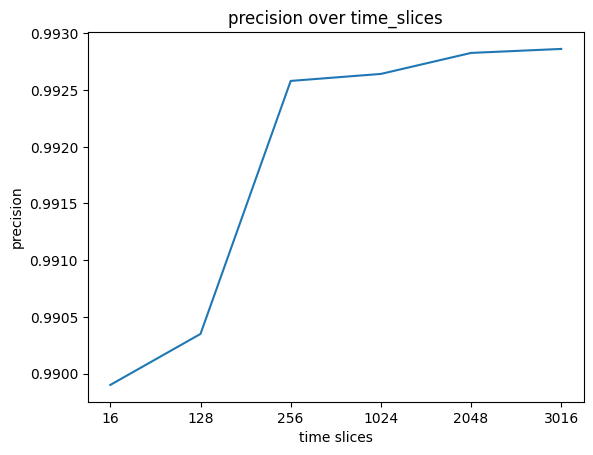

In [25]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
plt.show()

In [26]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}')
  print('\n')

Report 16: 
              precision    recall  f1-score        support
0              0.987988  0.999445  0.993684   90115.000000
1              0.997748  0.952891  0.974804   23244.000000
accuracy       0.989899  0.989899  0.989899       0.989899
macro avg      0.992868  0.976168  0.984244  113359.000000
weighted avg   0.989989  0.989899  0.989812  113359.000000


Report 128: 
              precision    recall  f1-score        support
0              0.988541  0.999445  0.993963   90115.000000
1              0.997753  0.955085  0.975953   23244.000000
accuracy       0.990349  0.990349  0.990349       0.990349
macro avg      0.993147  0.977265  0.984958  113359.000000
weighted avg   0.990430  0.990349  0.990270  113359.000000


Report 256: 
              precision    recall  f1-score        support
0              0.991305  0.999434  0.995353   90115.000000
1              0.997734  0.966013  0.981617   23244.000000
accuracy       0.992581  0.992581  0.992581       0.992581
macro avg     